<a href="https://www.kaggle.com/code/ntung110/telecom-customer-churn-eda-and-prediction?scriptVersionId=179818599" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [60]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv


In [21]:
# Install Required Libraries in Kaggle Directory
# !pip install optuna --target=/kaggle/working/
# !pip install shap --target=/kaggle/working/

In [61]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
import shap

import optuna
optuna.logging.disable_default_handler()

import warnings
warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.filterwarnings("ignore", "use_inf_as_na")

pd.set_option('display.max_columns', None)

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer

from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import (
    accuracy_score, confusion_matrix, classification_report,
    roc_auc_score, roc_curve, auc, f1_score, mean_squared_error,
    ConfusionMatrixDisplay
)

# Telecom Customer Churn EDA and Prediction 

### Primary Objectives
- Determine the correlation between customer demographics and plan pricing with respect to retention rates
- Predict new instances of customer churn using a multitude of classification algorithms
- Compare different classification algorithms using Accuracy, F1, and AUC metrics

### Sections
There are three major sections to this notebook
- Exploratory Data Analysis (EDA)
- Data Preprocessing
- Modelling and Hyperparameter Tuning
- Conclusion

# Exploratory Data Analysis (EDA)

We first perform a basic exposition of our dataset, which includes printing the dataset, its shapes, and the number of feature columns in the dataset.

In [62]:
df = pd.read_csv('/kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df.head(10)

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
5,9305-CDSKC,Female,0,No,No,8,Yes,Yes,Fiber optic,No,No,Yes,No,Yes,Yes,Month-to-month,Yes,Electronic check,99.65,820.5,Yes
6,1452-KIOVK,Male,0,No,Yes,22,Yes,Yes,Fiber optic,No,Yes,No,No,Yes,No,Month-to-month,Yes,Credit card (automatic),89.10,1949.4,No
7,6713-OKOMC,Female,0,No,No,10,No,No phone service,DSL,Yes,No,No,No,No,No,Month-to-month,No,Mailed check,29.75,301.9,No
8,7892-POOKP,Female,0,Yes,No,28,Yes,Yes,Fiber optic,No,No,Yes,Yes,Yes,Yes,Month-to-month,Yes,Electronic check,104.80,3046.05,Yes
9,6388-TABGU,Male,0,No,Yes,62,Yes,No,DSL,Yes,Yes,No,No,No,No,One year,No,Bank transfer (automatic),56.15,3487.95,No


In [63]:
print(df.shape)
print(df.size)

(7043, 21)
147903


In [64]:
df.columns

Index(['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents',
       'tenure', 'PhoneService', 'MultipleLines', 'InternetService',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling',
       'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn'],
      dtype='object')

### Feature Summary
- `customerID`: The customer's unique identification number
- `gender`: The customer's gender (male or female)
- `SeniorCitizen`: Indicates whether the customer is a senior (0 or 1)
- `Partner`: Indicates whether the customer has a partner (Yes or No)
- `Dependents`: Indicates whether the customer has dependents (Yes or No)
- `Tenure`: The customer's duration of stay with the company
- `PhoneService`: Indicates whether the customer has phone service (Yes or No)
- `MultipleLines` Indicates whether the customer has multiple lines (Yes or No or No phone service)
- `InternetService`: The customer's service provider (No, DSL, or Fiber Optic)
- `OnlineSecurity`: Indicates whether the customer has internet security (Yes, No or No internet service)
- `OnlineBackup`: Indicates whether the customer has online backup (Yes, No or No internet service)
- `DeviceProtection`: Indicates whether the customer has device protection (Yes, No or No internet service)
- `TechSupport`: Indciates whether the customer has tech support (Yes, No or No internet service)
- `StreamingTV`: Indicates whether the customer streams TV (Yes, No or No internet service)
- `StreamingMovies`: Indicates whether the customer streams movies (Yes, No, or No internet service)
- `Contract`: The customer's current contract term (Month-to-month, One year, Two year)
- `PaperlessBilling`: Indicates whether the customer has paperless billing (Yes or No)
- `PaymentMethod`: The customer's payment method (Electronic check, Mailed check, Bank transfer (automatic), Credit card (automatic))
-  `MonthlyCharges`: The monthly amount charged to the customer
-  `TotalCharges`: Total amount charged to the customer
- `Churn`: Indicates whether the customer has churn or not (Yes or No)

In [65]:
# Count missing values (null)
df.isnull().sum()

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64

In [66]:
# Count missing values (empty strings)
df.eq(' ').sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### Dealing with Missing Values
We can see that there are 11 missing values in the column`TotalCharges`. We could impute these rows now since the number of rows in the dataset exceeds that of rows with missing values (7043 >> 11). However, an important observation later shows that we can actually keep these rows without having to impute them.

For now, we will just convert the empty strings in the column 'TotalCharges' to numpy's default NaN value.

In [67]:
# Convert empty string to NaN and output these rows
df['TotalCharges'] = df['TotalCharges'].replace(" ", np.NaN)
df.isnull().sum()

customerID           0
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

### Feature Types
From the feature descriptions above, we can infer the types of each features.
- `customerID` &rarr; Object
- `gender` &rarr; Object
- `SeniorCitizen` &rarr; Boolean
- `Partner` &rarr; Boolean
- `Dependents` &rarr; Boolean
- `Tenure` &rarr; Int
- `PhoneService` &rarr; Boolean
- `MultipleLines` &rarr; Object
- `InternetService` &rarr; Object
- `OnlineSecurity` &rarr; Object
- `OnlineBackup` &rarr; Object
- `DeviceProtection` &rarr; Object
- `TechSupport` &rarr; Object
- `StreamingTV` &rarr; Object
- `Contract` &rarr; Object
- `PaperlessBilling` &rarr; Boolean
- `PaymentMethod` &rarr; Object
-  `MonthlyCharges` &rarr; Float
-  `TotalCharges` &rarr; Float
- `Churn` &rarr; Boolean

Where the classification of each types is as follows
- **Object:**: String-based values, features with more than three categories
- **Boolean**: Variables with boolean outputs, which we will later convert to int (0 or 1)
- **Float**: Decimal values
- **Int**: Integer values

In [68]:
df.dtypes

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object

### Mistyped Features
We notice that some of our features are initially mistyped. One notable column that affects our graphical summary and must be dealt with now is the column `TotalCharges`, whose type must be **float** instead of **object**. Other columns with yes/no output will be dealt with later in the data preprocessing stage.

In [69]:
# Converting TotalCharges to float
df['TotalCharges'] = df['TotalCharges'].astype(float)
df['TotalCharges'].dtypes

dtype('float64')

In [70]:
# Count number of unique values
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6530
Churn                  2
dtype: int64

### Check for Unique Entries
We can use the column `customerID` to check for unique entries in the dataset. After we have check for uniqueness, we can proceed to drop the column `customerID` altogether since its purpose is to index the entries and does not contain information that is analytical.

In [71]:
# Check if the number of unique entries in customerID matches the dataframe rows
print(df['customerID'].nunique() == df.shape[0])

True


In [72]:
# Result returns true so we drop column customerID
df = df.drop('customerID', axis = 1)

### Plotting our Data
Having cleaned our data, we can now proceed to make a graphical summary of all the features in our dataset.

We first split our columns into numerical features, boolean features, and categorical features. We will plot the following features using:
- **Numerical**: Histogram, Boxplot, Correlation Matrix
- **Categorical**: Barplot, Piechart

In [73]:
# Categorize features into numerical or categorical
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
cat_cols = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines',
                'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
              'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

### Numerical Summary

We first make a statistical summary of all the numerical features in our dataset

In [74]:
df[num_cols].describe()

,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7032.000000
mean,32.371149,64.761692,2283.300441
std,24.559481,30.090047,2266.771362
min,0.000000,18.250000,18.800000
25%,9.000000,35.500000,401.450000
50%,29.000000,70.350000,1397.475000
75%,55.000000,89.850000,3794.737500
max,72.000000,118.750000,8684.800000


A statistical summary of all the numerical features is as follows:
- **tenure**: The average of customer tenure is 32 months with a standard deviation of 25
- **MonthlyCharges**: The customer's average monthly charge is 65 dollars with a standard deviation of 30
- **Total**: The customer's total charges to the account is 2283 dollars with a standard deviation of 2266

We will now plot the histogram of the count of customers with respect to these numerical features.

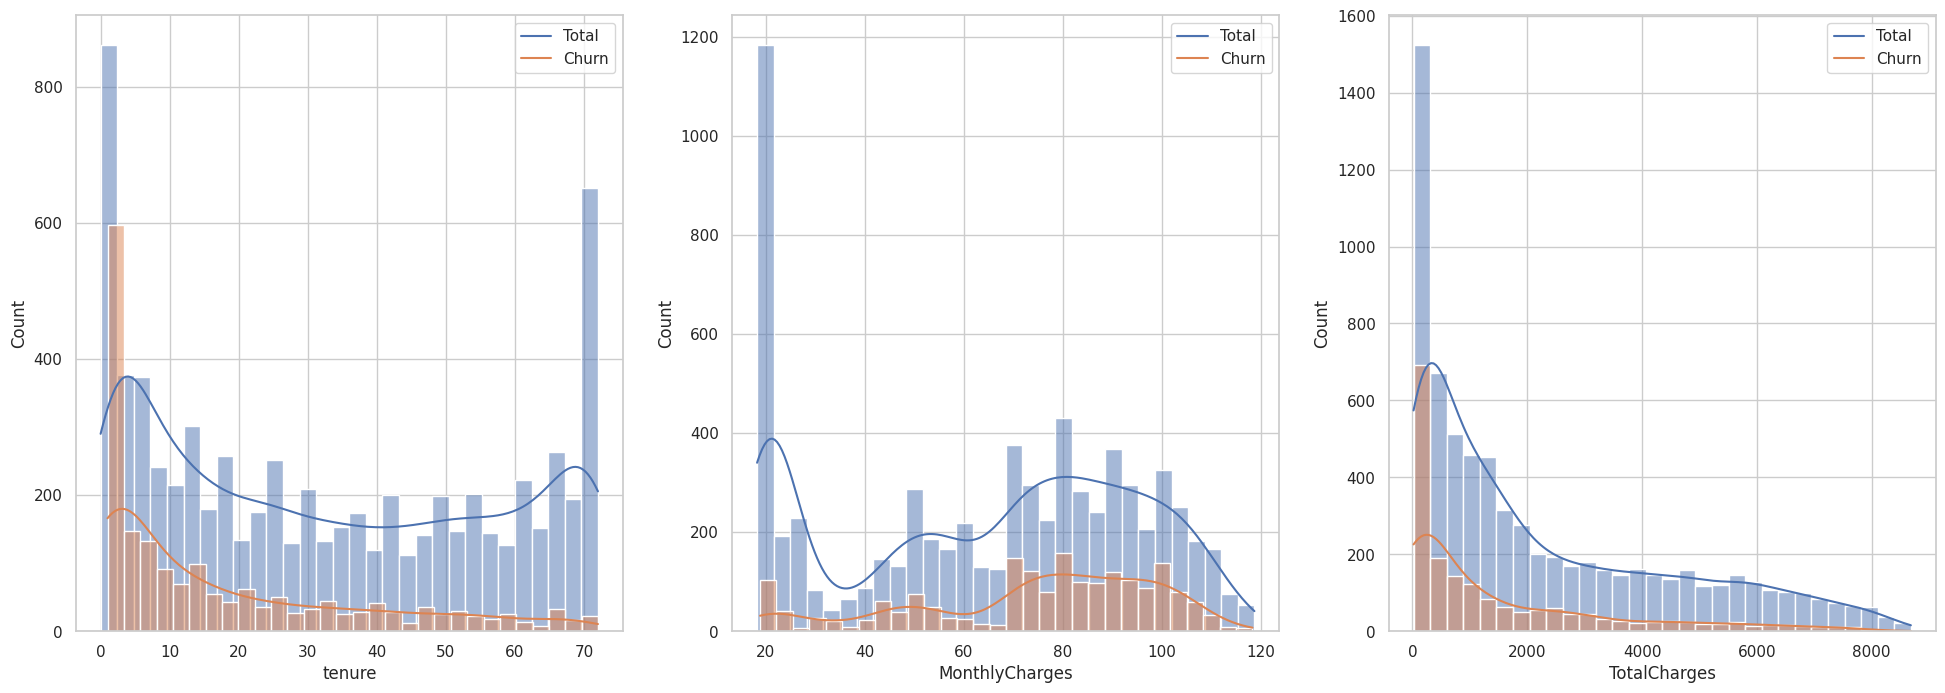

In [75]:
# Histograms of numerical features
plt.figure(figsize = (24,8))
sns.set(style = 'whitegrid', palette = 'deep')

ax1 = plt.subplot(1,3,1)
sns.histplot(data = df, x = 'tenure', bins = 30, kde = True)
sns.histplot(data = df.loc[df['Churn'] == 'Yes'], x = 'tenure', bins = 30, kde = True)
ax1.legend(labels = ['Total', 'Churn'])

ax2 = plt.subplot(1,3,2)
sns.histplot(data = df, x = 'MonthlyCharges', bins = 30, kde = True)
sns.histplot(data = df.loc[df['Churn'] == 'Yes'], x = 'MonthlyCharges', bins = 30, kde = True)
ax2.legend(labels = ['Total', 'Churn'])

ax3 = plt.subplot(1,3,3)
sns.histplot(data = df, x = 'TotalCharges', bins = 30, kde = True)
sns.histplot(data = df.loc[df['Churn'] == 'Yes'], x = 'TotalCharges', bins = 30, kde = True)
ax3.legend(labels = ['Total', 'Churn'])

<Axes: xlabel='Churn', ylabel='TotalCharges'>

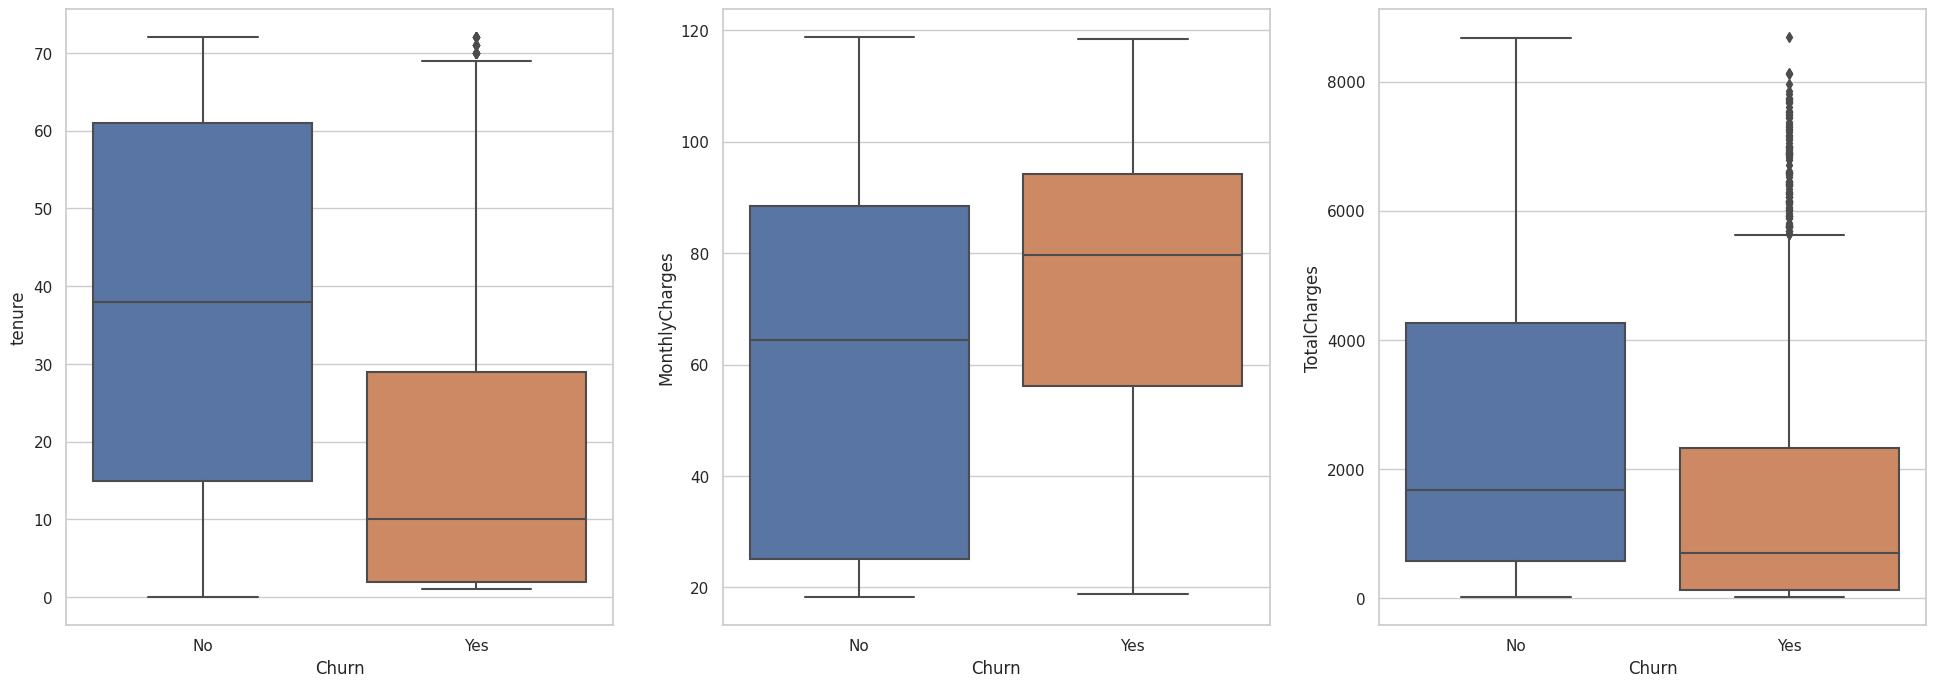

In [76]:
# Box plot of numerical features
plt.figure(figsize = (24,8))
sns.set(style = 'whitegrid', palette = 'deep')

plt.subplot(1,3,1)
sns.boxplot(data = df, x = 'Churn', y = 'tenure')

plt.subplot(1,3,2)
sns.boxplot(data = df, x = 'Churn', y = 'MonthlyCharges')

plt.subplot(1,3,3)
sns.boxplot(data = df, x = 'Churn', y = 'TotalCharges')

### Histogram & Box-Plot Analysis
Clearly, we can see that from the distribution of customers with respect to tenure that, customers who churned are likely to have low tenure, meaning that they have not sticked with the telecom plan for long. The distribution of customers who have not churned with respect to tenure is more evenly distributed.

In addition, notice that many of the customer who churned lies outside the interquantile range of total charges. This implies that there exist many churning customers whose total charges is considered significantly higher than the mean. This agrees with our distribution as it is highly skewed to the right compared to the other distributions.

### Correlation Matrix
We can graph the correlation matrix which represents the correlation between different numerical features as follows.

<Axes: >

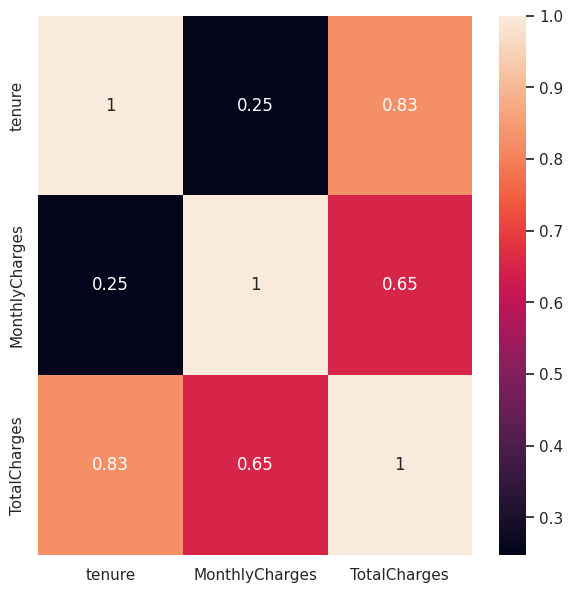

In [77]:
# Graphing the correlation between numerical features
plt.figure(figsize = (7,7))
sns.set(style = 'whitegrid')
sns.heatmap(df[num_cols].corr(), annot = True)

### Dropping `TotalCharges`

We notice that both the columns `tenure` and `MonthlyCharges` are highly correlated with the column `TotalCharges`, which indicates that `TotalCharges` is the culprit. Instead of just dropping the feature`TotalCharges` altogether without much explaination, I think it's better if we at least provide a justification for it.

Through some observation and domain knowledege, a customer's total accumulated charge must be at least **related** to the product of the customer's monthly charge and tenure. Indeed, if we plot the correlation matrix between `TotalCharges` and this product, which we will name `EstimatedCharges`, we see something interesting

      EstimatedCharges  TotalCharges
0                29.85         29.85
1              1936.30       1889.50
2               107.70        108.15
3              1903.50       1840.75
4               141.40        151.65
...                ...           ...
7038           2035.20       1990.50
7039           7430.40       7362.90
7040            325.60        346.45
7041            297.60        306.60
7042           6972.90       6844.50

[7043 rows x 2 columns]


<Axes: xlabel='EstimatedCharges', ylabel='TotalCharges'>

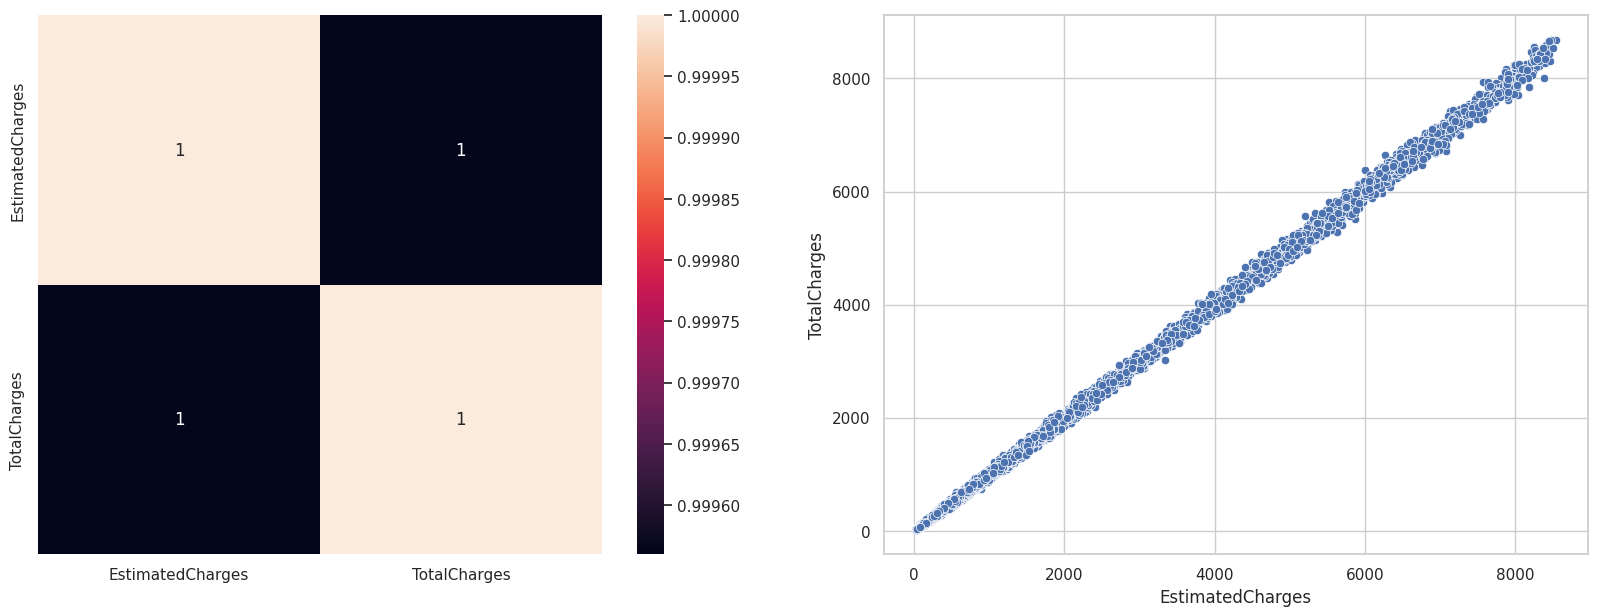

In [78]:
# Computing the elementwise product between tenure and monthlycharges
mult = df[["MonthlyCharges"]].multiply(df["tenure"], axis="index")
mult = mult.rename(columns={"MonthlyCharges" : "EstimatedCharges"})
mat = pd.concat([mult, df['TotalCharges']], axis = 1)
print(mat)

plt.figure(figsize = (20,7))
sns.set(style = 'whitegrid')

# Graphing the correlation matrix
plt.subplot(1,2,1)
sns.heatmap(mat.corr(), annot = True)

# Graphing a scatterplot of all entries
plt.subplot(1,2,2)
sns.scatterplot(data = mat, x = 'EstimatedCharges', y = 'TotalCharges')

We see that the correlation between features `EstimatedCharges` and `TotalCharges` are identically 1, which indicates that these two features are perfectly positively correlated. Indeed, the scatterplot for these two features agrees with our analysis.

Now, should we drop the two features `MonthlyCharges` and `tenure` which makes up our `EstimatedCharges`, or the feature `TotalCharges`? 

Indeed on the basis of keeping the most information available, we should drop the column`TotalCharges` since we can certainly (approximately) derive this column by multiplying `MontlyCharge` and `tenure`, but we cannot derive the other two columns using `TotalCharges` only.

In [79]:
# Drop TotalCharges
df = df.drop('TotalCharges', axis = 1)

### Categorical Summary

We now perform a categorical summary of all the categorical features in our data.

In [80]:
# Convert SeniorCitizen to object first (we will convert back to int64 later) 
df['SeniorCitizen'] = df['SeniorCitizen'].astype('object')
df[cat_cols].describe(include = 'object')

,gender,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod
count,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043,7043
unique,2,2,2,2,2,3,3,3,3,3,3,3,3,3,2,4
top,Male,0,No,No,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check
freq,3555,5901,3641,4933,6361,3390,3096,3498,3088,3095,3473,2810,2785,3875,4171,2365


In [81]:
# Useful Helper Function
def annotate_percent(ax, df, total):
    for p in ax.patches:
        percentage = '{:.1f}%'.format(100 * p.get_height() / total)
        x = p.get_x() + p.get_width() / 2
        y = p.get_height() / 2
        ax.annotate(percentage, (x,y), ha = 'center', fontsize = 15,  weight = 'bold')

### Churning Rates
We want to investigate the number of customers who have and have not churned. This will inform our decision when it comes to analyzing other categorical variables in our data

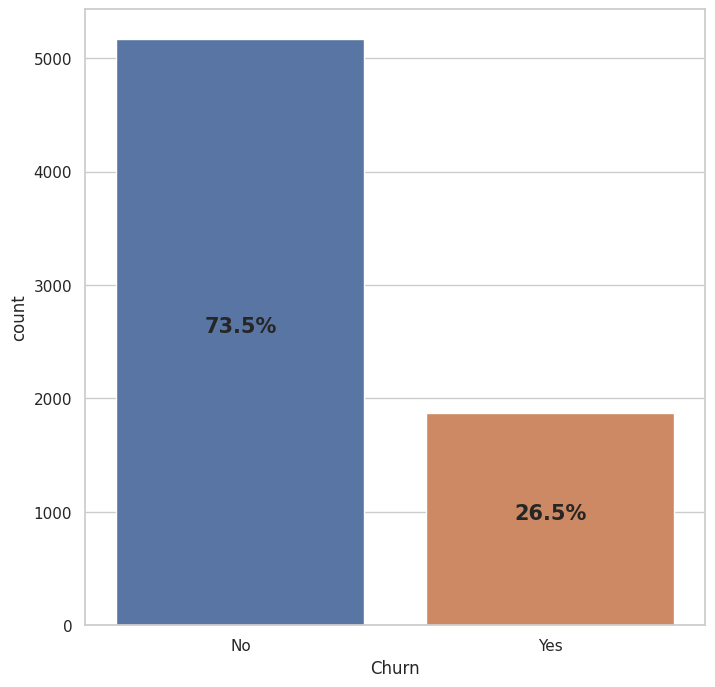

In [82]:
# Churning Rates
plt.figure(figsize = (8,8))
sns.set(style = 'whitegrid')
ax = sns.countplot(data = df, x = 'Churn')
annotate_percent(ax, df, df.shape[0])

We can see that the dataset is **slightly imbalanced**, since the customers that do not churn account for 3/4 of the dataset compared to the instances that churned. While there are certain techniques that will help us achieve a balanced dataset, either by undersampling the majority class or oversampling the minority class using generated data (through algorithms like SMOTE), we will not consider them here.

### Customer Demographics

We would want to identify common themes between the columns `gender`, `SeniorCitizen`, `Partner`, and `Dependents` since it relates to the customer's personal status.

We first perform a count of all of these columns along with their percentages

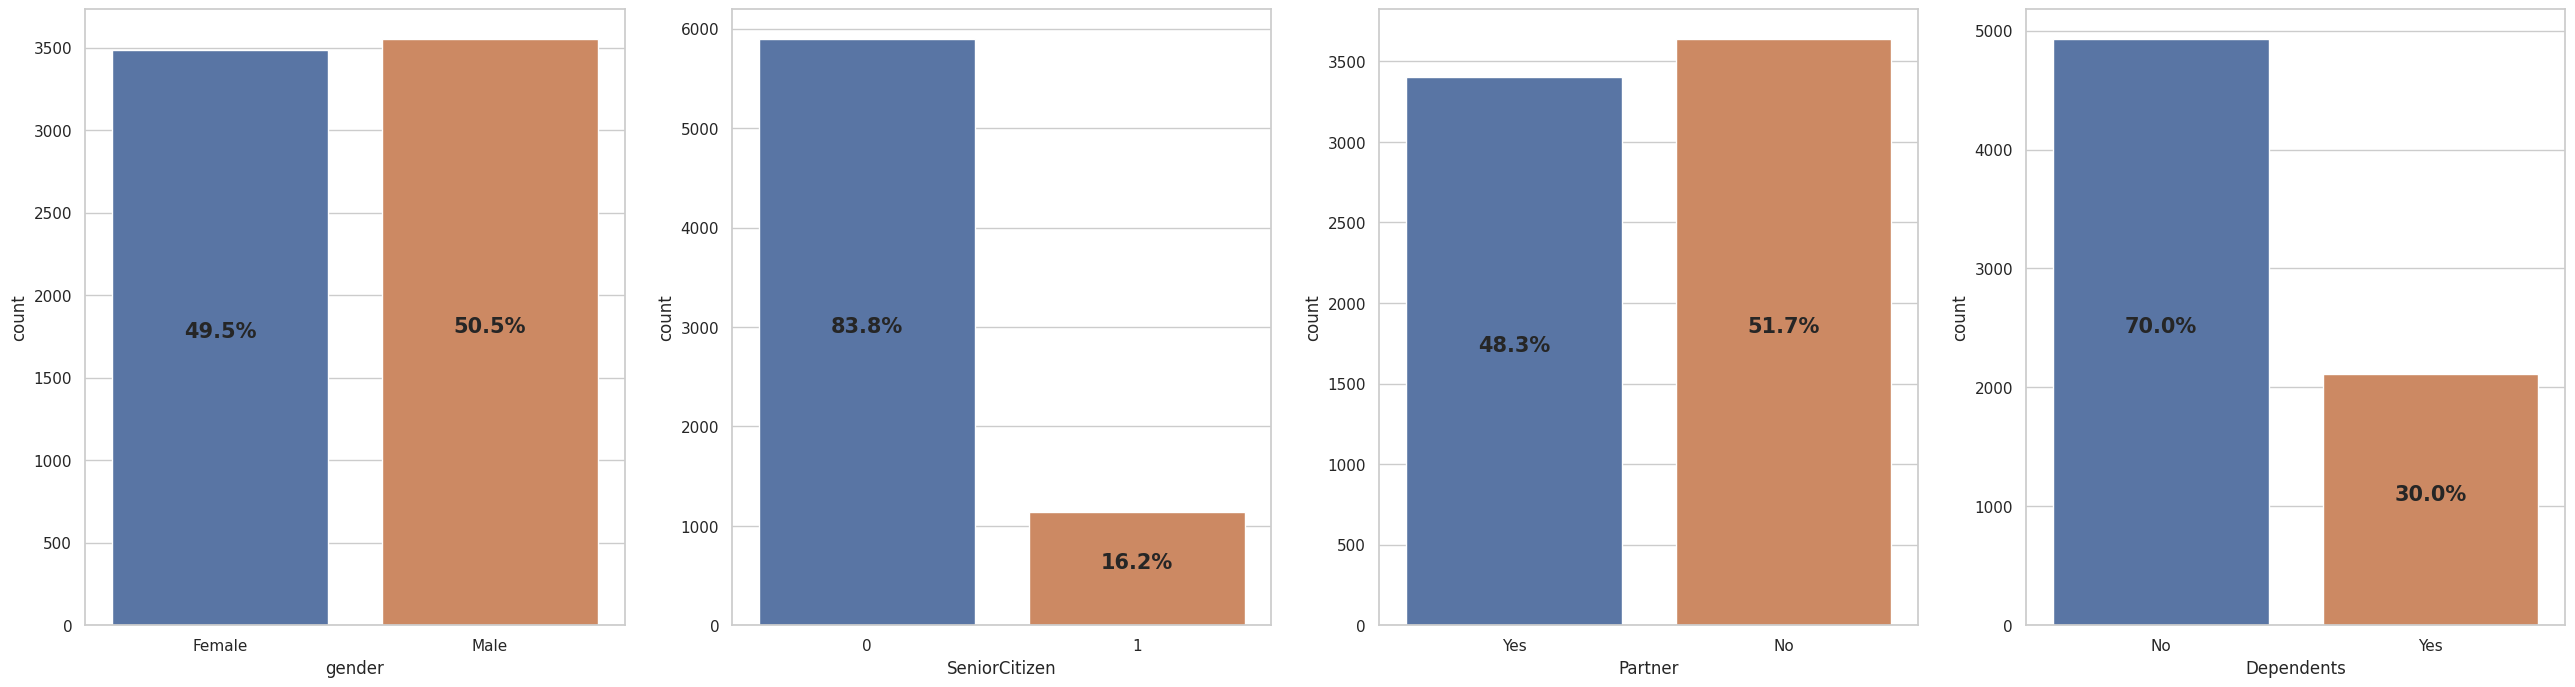

In [83]:
# Perform a Categorical Summary
plt.figure(figsize = (32,8))
sns.set(style = 'whitegrid')

plt.subplot(1,4,1)
ax1 = sns.countplot(data = df, x = 'gender')
annotate_percent(ax1, df, df.shape[0])

plt.subplot(1,4,2)
ax2 = sns.countplot(data = df, x = 'SeniorCitizen')
annotate_percent(ax2, df, df.shape[0])

plt.subplot(1,4,3)
ax3 = sns.countplot(data = df, x = 'Partner')
annotate_percent(ax3, df, df.shape[0])

plt.subplot(1,4,4)
ax4 = sns.countplot(data = df, x = 'Dependents')
annotate_percent(ax4, df, df.shape[0])

We can see that there is roughly an even distribution of the number of males and females in our dataset. In addition, about half of our customers have partners.

We would like to explore the correlation between `Dependents` given `Partner`, and `SeniorCitizen`. According to our domain knowledge, a person whose is with a partner is more likely to have children as dependents. People who identified as seniors might have partners, but are likely to not have dependents (children might have become adults)

However, these are just speculations that will help guide our data analysis.

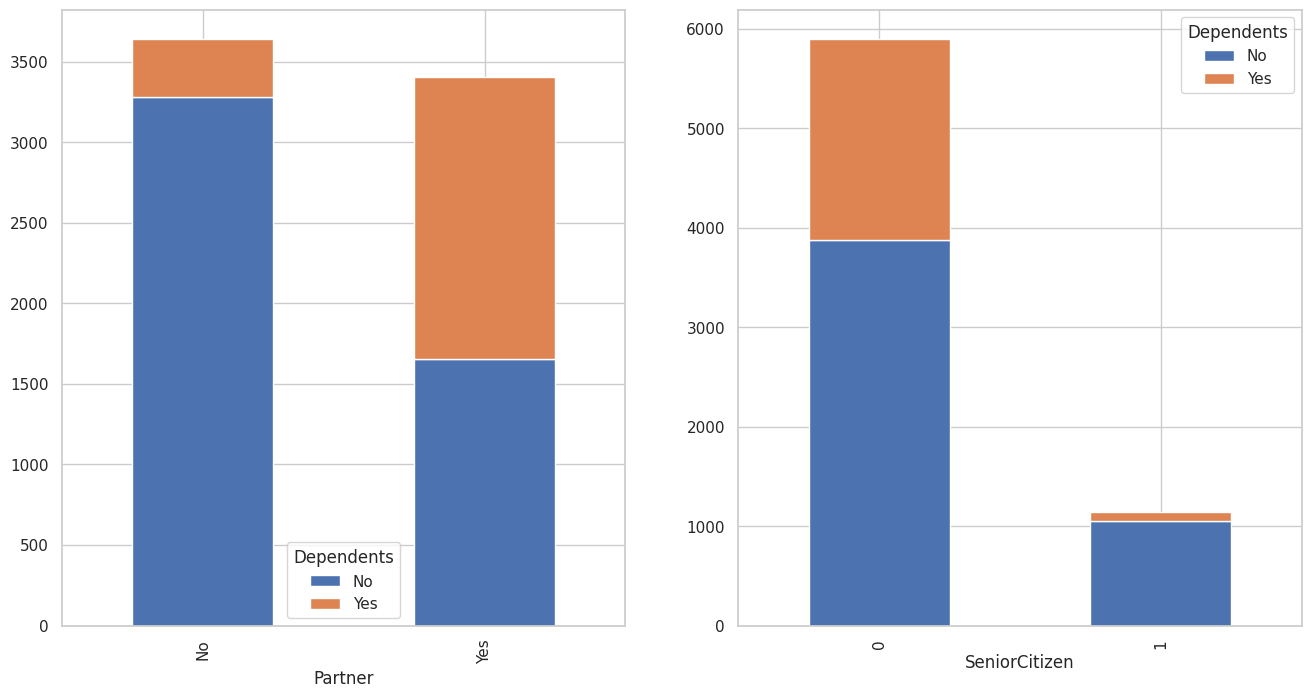

In [85]:
# Graph the number of dependents conditioned on partners
fig, axes = plt.subplots(1,2, figsize = (16,8))

# Group Counts
count_partner = df.groupby(['Partner', 'Dependents']).size().unstack(fill_value = 0)
count_senior = df.groupby(['SeniorCitizen', 'Dependents']).size().unstack(fill_value = 0)

# Plot
count_partner.plot(kind = 'bar', stacked = True, ax = axes[0])
count_senior.plot(kind = 'bar', stacked = True, ax = axes[1])

We can see that the number of customers with partners who have dependents accounts for around 50%, whereas the number of customers without partners  who have dependents accounts for a fraction of that. This means that customers who have partners are more likely to have dependents (most likely children) as opposed to customers with no partners.

In addition, the number of senior citizens who have dependents account for very little compared to the number of senior citizen who have no dependents. This result makes sense since past dependents of seniors (which we can assume to be children) are more likely to be independent given the age range.

### Phone & Internet Services

We would want to graph the number of customers who have phone and internet services (the column `PhoneService` and `InternetService`), as well as the number of registered customers for each feature associated with phone services and internet services (`MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, `StreamingMovies`)

In [ ]:
# Plots of phone services
plt.figure(figsize = (16,8))
sns.set(style = 'whitegrid')

phone_cols = ['PhoneService', 'MultipleLines']
df_phone = df[phone_cols]
cnt = 0

for lbl in phone_cols:
    plt.subplot(1,2,cnt + 1)
    ax = sns.countplot(data = df, x = lbl)
    annotate_percent(ax, df_phone, df_phone.shape[0])
    cnt += 1

In [ ]:
# Plots of internet services 

plt.figure(figsize = (32,16))
sns.set(style = 'whitegrid')

axes = []
inter_cols = ['InternetService', 'OnlineSecurity', 'OnlineBackup', 
              'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
df_internet = df[inter_cols]
cnt = 0

for lbl in inter_cols:
    plt.subplot(2,4, cnt + 1)
    ax = sns.countplot(data = df, x = lbl)
    axes.append(ax)
    annotate_percent(axes[cnt], df_internet, df_internet.shape[0])
    cnt += 1

An observation shows that the percentage of customers who have phone service is the same as the number of people who don't have multiple lines. Additionally, the percentage of customers with no internet service is the same for all seven plot. This is worth investigating over.

In [ ]:
df_phone[df['PhoneService'] == 'No']

In [ ]:
df_internet[df['InternetService'] == 'No']

In [ ]:
# Verify our assumption for phone service
mask = ((df_phone['PhoneService'] == 'No') & (df_phone['MultipleLines'] == 'No phone service'))
comp = (df_phone.loc[mask] == df_phone[df['PhoneService'] == 'No'])
comp.value_counts()

In [ ]:
# For internet service
mask = df_internet['InternetService'] == 'No'
for lbl in inter_cols: 
    if lbl != 'InternetService':
        mask = mask & (df_internet[lbl] == 'No internet service')

comp = (df_internet[df_internet['InternetService'] == 'No']) == df_internet.loc[mask]
comp.value_counts()

As we have compared every entry in the dataframe with our condition, we can verify that indeed, if a customer has no internet service (resp. no phone service), then they **cannot** sign up to any additional features that requires internet service (resp. phone service) to use. This correctly aligns with our domain knowledege and is clearly obvious.

We will later use this to our advantage during the data preprocessing stage.

### Churning Rates & Service Registered

The number of service registered (including both phone and internet services) with respect to churning rates is worth investigating over. Let's first count the number of services that each customer's registered. Then, we can use this information to graph a histogram with respect to the number of customers including churning rates.

Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


9


When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.


<Axes: xlabel='Service Count', ylabel='MonthlyCharges'>

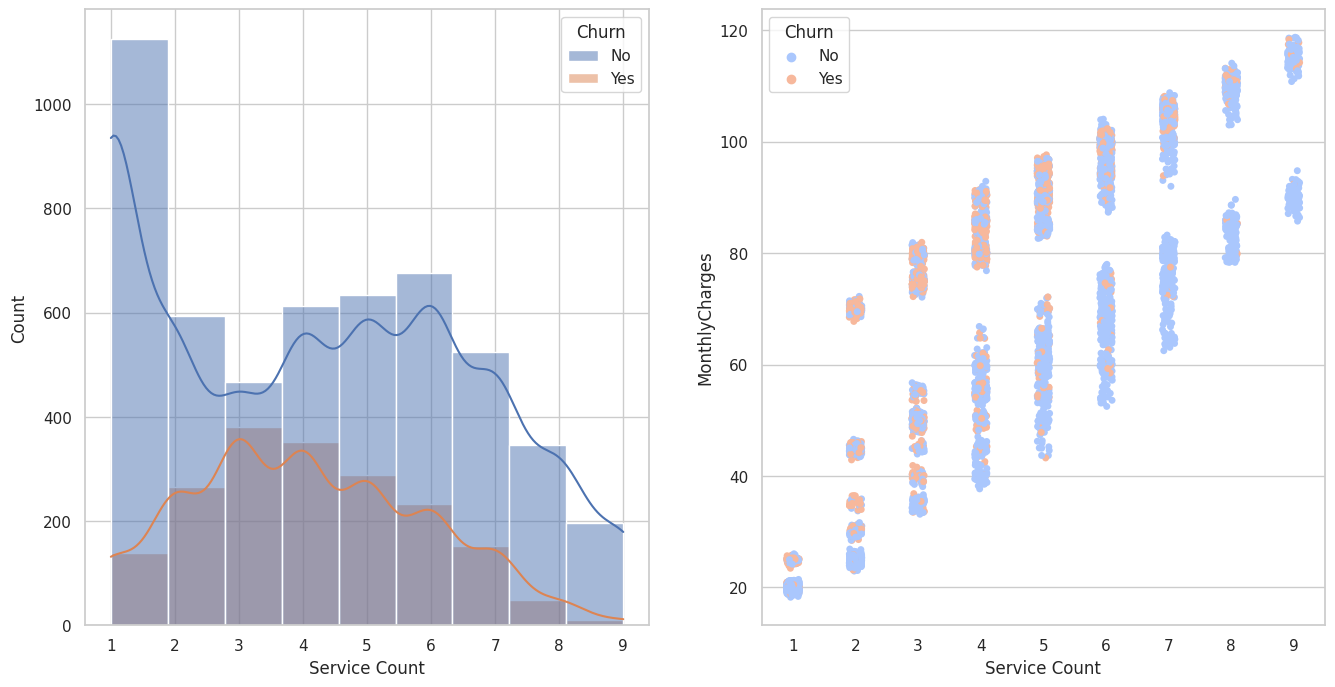

In [58]:
# Perform a count of services
temp = df[phone_cols + inter_cols]
registered_map = {'No' : 0, 'No phone service' : 0, 'No internet service' : 0, 'Yes' : 1, 'DSL' : 1, 'Fiber optic': 1}
service_count = pd.Series(data = temp.replace(registered_map).sum(axis = 1), name = 'Service Count')

# Prepare data for plotting
data = pd.concat([service_count, df['MonthlyCharges'], df['Churn']], axis = 1)
max_val = service_count.max()
print(max_val)

# Plot the histogram
plt.figure(figsize = (16,8))
sns.set(style = 'whitegrid')

plt.subplot(1,2,1)
sns.histplot(data = data, x = 'Service Count', hue = 'Churn',  bins = max_val, kde = True)

plt.subplot(1,2,2)
pal = 'coolwarm'
sns.stripplot(data = data, x = 'Service Count', y = 'MonthlyCharges', hue = "Churn", palette = pal)

### Further Analysis
From the histograms, we can infer the following statements:
- There is a positive correlation between the number of service registered and the monthly price
- The percentage of customers who churned reaches maximum at 3-4 services, whereas the number of customers who have signed on 1 or 9 services are the least likely to churn percentage-wise
- The number of customers registered decreases as the number of service registered increases, peaked at around 1 service registered and concentrated around 5 and 6 services.
- In combination with the price scatterplot, we can see that the monthly price that these customers incurred hovers around the 70 - 90 dollar range

### Financial Status

Lastly, we would like to explore the number of customers with respect to contract types (column `Contract`), and methods of payment (columns `PaperlessBilling` and `PaymentMethod`)

In [ ]:
# Plot relevant figures

plt.figure(figsize = (24, 8))
sns.set(style = 'whitegrid')

plt.subplot(1,3,1)
ax1 = sns.countplot(data = df, x = 'Contract')
annotate_percent(ax1, df, df.shape[0])

plt.subplot(1,3,2)
ax2 = sns.countplot(data = df, x = 'PaperlessBilling')
annotate_percent(ax2, df, df.shape[0])

plt.subplot(1,3,3)
ax3 = sns.countplot(data = df, x = 'PaymentMethod')
annotate_percent(ax3, df, df.shape[0])

### Tenure and Types of Contract
It is worth it to explore the types of contract in correlation to the customer's tenure in months, along with churning rates.

In [ ]:
plt.figure(figsize = (24,8))
sns.set(style = 'whitegrid')

plt.subplot(1,3,1)
ax1 = sns.histplot(data = df[df['Contract'] == 'Month-to-month'], x = 'tenure', hue = 'Churn', bins = 30, kde = True)
ax1.set_title('Tenure of customers with month-to-month contracts')

plt.subplot(1,3,2)
ax2 = sns.histplot(data = df[df['Contract'] == 'One year'], x = 'tenure', hue = 'Churn', bins = 30, kde = True)
ax2.set_title('Tenure of customers with one-year contracts')

plt.subplot(1,3,3)
ax3 = sns.histplot(data = df[df['Contract'] == 'Two year'],  x = 'tenure', hue =  'Churn', bins = 30, kde = True)
ax3.set_title('Tenure of customers with two-year contracts')

### Explaination
We can see that the majority of customers with one-month-contract and short tenure are the most likely culprit for churning. The number of churning customers are especially high at the first three months since customers are not too invested in the telecom plans. As tenure increases, the number of churning customers with one-month-contracts decreases significantly.

Customers with one-year contracts usually dropped after a few renewals of the one-year plan, with the number increasess significantly at the start of renewal (tenure = 11, 23, 35, ...). The number of churning customers are high after the third and fourth renewal of the plan.

Customers with two-year plans are less likely to drop the plan since a commitment to a two-year plan implies a higher base satisfactory level for customers, since otherwise they would have signed up for monthly or annual plans.

### Payment Method

For the payment method, we will analyze the number of customers that are registed for automatic payment (Bank transfer, Credit Card) or manual deposits (Electronic or Mailed Check) in relation to churning rates.

In [ ]:
# Payment Method
dt = {'Bank transfer (automatic)' : 'auto', 'Credit card (automatic)' : 'auto',
     'Electronic check' : 'manual', 'Mailed check' : 'manual'}
def map_payment(elem):
    return dt[elem]

payment = df['PaymentMethod'].map(map_payment)
payment = pd.concat([payment, df['Churn']], axis = 1)

# Plot the count of people
plt.figure(figsize = (16,8))
sns.set(style = 'whitegrid')

plt.subplot(1,2,1)
ax1 = sns.countplot(data = payment.loc[payment['PaymentMethod'] == 'auto'], x = 'Churn')
annotate_percent(ax1, payment, payment.shape[0])

plt.subplot(1,2,2)
ax2 = sns.countplot(data = payment.loc[payment['PaymentMethod'] == 'manual'], x = 'Churn')
annotate_percent(ax2, payment, payment.shape[0])

We can see that the number of people whose payment method are manual are 2.5 times more likely to churn compared to people who set their payment method to automatic.

# Data Preprocessing

### A Note on Data Leakage
The reason that we can apply data preprocessing on categorical variables (which we will in this section) before we have splitted the data each entry is guaranteed to be associated with values that are listed in the description of the feature. As such, we can perform these steps without much concern for data leakage.

Numerical features, on the other hand, is sensitive to data leakage. Thus, we **cannot** perform data preprocessing on numerical features now as we have not split the dataset yet. We will process numerical features after we have split the dataset.

As a general rule of thumb, it is always advisable to first split the data before any preprocessing techniques is to be done.

### Boolean Feature Conversion
From our variable summary and type inference, we can see that some features in the dataset are of undesirable type. The list of which is as follows:
- `Partner`: object &rarr; boolean
- `Dependents`: object &rarr; boolean
- `PhoneService`: object &rarr; boolean
- `PaperlessBilling`: object &rarr; boolean
- `TotalCharges`: object &rarr; float64
- `Churn`: object &rarr; boolean

We proceed to convert these columns into our required type, as well as mapping features with yes/no to corresponding boolean outputs (1 and 0)

In [ ]:
# Boolean Conversion (yes/no to 1/0)
bool_map = {'No' : 0, 'Yes' : 1}
bool_cols = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

for lb in bool_cols:
    df[lb] = df[lb].map(bool_map)

# Verify that all boolean conversions are correct
for x in bool_cols:
    print(f"Feature '{x}' has unique values: {df[x].unique()}")
print(df[bool_cols].dtypes)

### "Partially" Boolean Features
An observation in our dataset reveals that a number of features in our dataset is conditionally related to each other. Specifically:
- If the value of the column `PhoneService` is No, then the value of `MultipleLines` is guaranteed to be "No Phone Service"
- If the value of the column `InternetService` is No, then the value of the columns `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies` is guranteed to be "No Internet Service".

Using our domain knowledge, this result is predictable. A customer cannot add multiple lines if they have no phone services, and cannot add extra features on their internet plans if they have no internet altogether.

In addition, we notice that `No Phone Service` and `No Internet Service` are just extensions of the entry `No` encoded with the information from th e respective columns `PhoneService` and `InternetService`. Since we have already saved this "extra" information by keeping `PhoneService` and `InternetService`, it suffices to just convert these to `No` altogether without the loss of any information.

Using the same boolean conversion technique as above, we will convert the columns `MultipleLines`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV`, and `StreamingMovies` to its boolean representations.

In [ ]:
# Convert SeniorCitizen back to boolean
df['SeniorCitizen'] = df['SeniorCitizen'].astype(int)
# Boolean Conversion (yes/no or no internet/phone service to 1/0)
bool_map_extended = {'No' : 0, 'Yes' : 1, 'No internet service' : 0, 'No phone service' : 0}
partial_bools = ['MultipleLines','OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
                 'TechSupport', 'StreamingTV', 'StreamingMovies']

for lb in partial_bools:
    df[lb] = df[lb].map(bool_map_extended)
partial_bools.append('SeniorCitizen')

# Verify that all boolean conversions are correct
for x in partial_bools:
    print(f"Feature '{x}' has unique values: {df[x].unique()}")
print(df[partial_bools].dtypes)

### Label Encoding

We can see that the column `InternetService` is an ordinal categorical feature since we can impose an order on our internet service as `No` < `DSL` < `Fiber optic`.

The most suitable method for encoding this column is to use label encoding to suitably label these instances whilst preserving its order.

In [ ]:
# Label encode data
print(df['InternetService'].value_counts())
label_encode = {'No' : 0, 'DSL' : 1, 'Fiber optic' : 2}
df['InternetService'] = df['InternetService'].map(label_encode)
print(df['InternetService'].value_counts())

### One Hot Encoding
We see that the rest of our categorical features, `Contract` and `PaymentMethod`, are nominal categorical with more than 2 features. Since the number of features in these columns are relatively small, we can employ One Hot Encoding on these columns to retain maximum information. 

In addition, since the categories in these columns are "linearly dependent" (e.g. a contract term that is not month-to-month and one-year is two-year),  we can drop the first category to ensure linearly independent columns.

In [ ]:
# One Hot Encoding
onehot_gender = pd.get_dummies(df['gender'], drop_first = True, dtype = int)
onehot_contract = pd.get_dummies(df['Contract'], drop_first = True, dtype = int)
onehot_payment = pd.get_dummies(df['PaymentMethod'], drop_first = True, dtype = int)
df = pd.concat([df, onehot_gender, onehot_contract, onehot_payment], axis = 1)

# Drop original columns
df = df.drop(['gender', 'Contract', 'PaymentMethod'], axis = 1)
df

### Splitting The Dataset

We want to first split the data into three different parts
- Training data: which is used to train the model
- Cross-Validation data: which is used later for retraining / hyperparameter tuning 
- Test data: which is used to blind-test the model to measure true accuracy

We will split with stratify for the training data and the cross-validation data, while performing a random split on the test data to mimic the process of collecting new data.

In [ ]:
# Split data
X = df.drop('Churn', axis = 1)
y = df['Churn']

X_rest, X_test, y_rest, y_test = train_test_split(X,y, test_size = 0.2, random_state = 1)
X_train, X_cv, y_train, y_cv = train_test_split(X_rest, y_rest, test_size = 0.2, random_state = 2, stratify = y_rest)

# Print shape of training, test, and cross-validation data
print(f"Training Data Shape: {X_train.shape}")
print(f"Training Target Shape: {y_train.shape}")
print(f"Cross-Validation Data Shape: {X_cv.shape}")
print(f"Cross-Validation Target Shape: {y_cv.shape}")
print(f"Test Data Shape: {X_test.shape}")
print(f"Test Target Shape: {y_test.shape}")

### Numerical Transformations
As observed in our EDA process, we can see that some of our numerical features only lightly resembles a Gaussian Distribution, which will impact the performance of some of our ML models later on. It would be desirable if we can transform our numerical features such that it bares more resemblence to the Gaussian

We can do exactly this via sklearn's multiple numerical transformers as follows.

**Note:** This section requires a lot of experimentation and so the process for doing this is not entirely cut-and-dry. This is just a summary of my work.

### Standardization
We first want to standardize the dataset to zero mean and unit variance first as many machine learning models assume standardization. This process is crucial for obtaining the best performance from our models later on.

In [ ]:
# Specify numerical columns
num_cols = ['tenure', 'MonthlyCharges']
scaler = StandardScaler()
scaler.fit(X_train[num_cols])

# Transform the training, cross validation, and test set
X_train_num_new = scaler.transform(X_train[num_cols])
X_cv_num_new = scaler.transform(X_cv[num_cols])
X_test_num_new = scaler.transform(X_test[num_cols])

# Convert to Pandas Dataframe
X_train_num_new = pd.DataFrame(X_train_num_new, columns = num_cols)
X_cv_num_new = pd.DataFrame(X_cv_num_new, columns = num_cols)
X_test_num_new = pd.DataFrame(X_test_num_new, columns = num_cols)

# Plot the training set as reference to verify correct scaling
plt.figure(figsize = (16,16))
sns.set(style = 'whitegrid')

plt.subplot(2,2,1)
sns.histplot(data = X_train['tenure'], bins = 30, kde = True)

plt.subplot(2,2,2)
sns.histplot(data = X_train_num_new['tenure'], bins = 30, kde = True)

plt.subplot(2,2,3)
sns.histplot(data = X_train['MonthlyCharges'], bins = 30, kde = True, color = 'orange')

plt.subplot(2,2,4)
sns.histplot(data = X_train_num_new['MonthlyCharges'], bins = 30, kde = True, color = 'orange')

### Quantile Transformer

We can transform the column `tenure` and `MonthlyCharges` using a Quantile Transformer function, which is a common non-parametric statistical method used to transform the dataset into a Gaussian Distribution. This is included in scikit-learn preprocessing libary, named `QuantileTransformer`

In [ ]:
# Quantile Transformer
# X_train_num_new['tenure'] = np.log(X_train_num_new['tenure'])
# X_test_num_new['tenure'] = np.log(X_test_num_new['tenure'])
# X_cv_num_new['tenure'] = np.log(X_cv_num_new['tenure'])

qt = QuantileTransformer(output_distribution = 'normal')
qt.fit(X_train_num_new)

# Transform the columns tenure and monthly charges
X_train_trans = qt.transform(X_train_num_new)
X_cv_trans = qt.transform(X_cv_num_new)
X_test_trans = qt.transform(X_test_num_new)

# Convert to Pandas DataFrame
num_cols_trans = ['tenure(trans)', 'MonthlyCharges(trans)']
X_train_trans = pd.DataFrame(X_train_trans, columns = num_cols_trans)
X_cv_trans = pd.DataFrame(X_cv_trans, columns = num_cols_trans)
X_test_trans = pd.DataFrame(X_test_trans, columns = num_cols_trans)

# Graph the instances on a histogram
plt.figure(figsize = (16,24))
sns.set(style = 'whitegrid')

# Tenure
plt.subplot(4,2,1)
sns.histplot(data = X_train_num_new['tenure'], bins = 30, kde = True)

plt.subplot(4,2,2)
sns.histplot(data = X_train_trans['tenure(trans)'], bins = 30, kde = True)
             
plt.subplot(4,2,3)
sns.boxplot(data = X_train_num_new['tenure'])

plt.subplot(4,2,4)
sns.boxplot(data = X_train_trans['tenure(trans)'])

# Monthly Charges
plt.subplot(4,2,5)
sns.histplot(data = X_train_num_new['MonthlyCharges'], bins = 30, kde = True, color = 'Orange')

plt.subplot(4,2,6)
sns.histplot(data = X_train_trans['MonthlyCharges(trans)'], bins = 30, kde = True, color = 'Orange')
             
plt.subplot(4,2,7)
sns.boxplot(data = X_train_num_new['MonthlyCharges'], color = 'Orange')

plt.subplot(4,2,8)
sns.boxplot(data = X_train_trans['MonthlyCharges(trans)'], color = 'Orange')

### Final Result
We can now save everything to our original dataset. Here is the final dataset, ready for modelling.

In [ ]:
# Drop original tenure and monthlycharges column
X_train = X_train.drop(num_cols, axis = 1)
X_cv = X_cv.drop(num_cols, axis = 1)
X_test = X_test.drop(num_cols, axis = 1)

# Save dataset for modelling
X_train = pd.concat([X_train_trans.reset_index(drop = True), X_train.reset_index(drop = True)], axis = 1)
X_cv = pd.concat([X_cv_trans.reset_index(drop = True), X_cv.reset_index(drop = True)], axis = 1)
X_test = pd.concat([X_test_trans.reset_index(drop = True), X_test.reset_index(drop = True)], axis = 1)

# Print dataset
X_train

# Modelling & Hyperparameter Tuning

### Classification Models
After having preprocessed our dataset, we can now turn our attention into using this dataset to train our classification algorithms, which will allow us to predict new instances of potential churners in our network. We will employ a number of different classfication learning algorithms and evaluate between them to choose the best model for our purposes. Specifically, the following classification models will be chosen:
- Logistic Regression
- K-Nearest Neighbours (KNN)
- Support Vector Machines (SVM)
- Tree Ensembles (Decision Trees, Random Forest, XGBoost)

### Choosing a Metric for Comparison

It is important that we first choose a metric that we will base our model evaluation upon. We can do so via an analysis of the confusion matrix, which gives us the true positive, false positive, false negative, and true negative values for our predictions.

As we have specified, the goal is to identify customers that will potentially churn, usually to identify areas for improvements for our telecom service. As such, it is more important that we correctly identify all customers that will churn, even if we flagged them as wrong. As such, **Recall** and **AUC** would be the best metric here to use.

A lesser important metric that will help us is the **Precision** score. In essence, out of all of our true predictions, we would want the largest percentage of that to correctly identify the number of customers with intention of churning. This means that we can focus our capital on the demographic that is more likely to churn, rather than existing happy customers.

Optimizing both precision and recall is a tradeoff, so we wish to choose the value such that precision and recall are both high, but equidistant to each other. We can do so using the **F1 score**, which is the harmonic mean of these two quantities.

Lastly, we will also be looking at the **accuracy** of the model to gauge the general performance of our predictive model. However, since our dataset is a little imbalanced, focusing on accuracy alone is unhelpful and so we put it as our least (but still important) metrics.

So the metrics that we will use to evaluate our learning algorithms are **F1 score, AUC, and Accuracy.**



### Reporting Metrics

We first construct a function that will conveniently print out all of our scored metrics.
- The first function `metrics_report` reports the precision, recall, and F1 score of our algorithm. It also prints the accuracy and the confusion matrix associated with a predicition
- The second function `roc_print` prints the ROC curve and AUC score of an sklearn model
- The third function `produce_score` returns an array with relevant metrics (Accuracy, AUC, F1)
- `FINAL_RESULT` is a DataFrame that contains the final prediction metrics of all models after tuning relevant hyperparameters

In [ ]:
# Useful functions for evaluation

def roc_print(y_true, y_pred):
    
    # Calculate ROC curve
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    
    # Plot ROC curve
    plt.title('ROC Curve')
    plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % auc_score)
    plt.legend(loc = 'lower right')
    plt.plot([0, 1], [0, 1],'r--')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.ylabel('True Positive Rate (TPR)')
    plt.xlabel('False Positive Rate (FPR)')
    plt.show()
    
def print_metrics(y_true, y_pred):
    
    # Calculate metrics
    score = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    fpr, tpr, _ = roc_curve(y_true, y_pred)
    auc_score = auc(fpr, tpr)
    
    # Output to console
    print("---------- Metrics ----------")
    print(f"Accuracy: {score}")
    print(f"F1 score: {f1}")
    print(f"AUC score: {auc_score}")
    
    return [score, f1, auc_score]
FINAL_RESULT = []

### Logistic Regression

The first method is to try Logistic Regression, which is a widely-used classical machine learning algorithm. 

We first try to compute the scoring metrics on our training set first to get a rough idea of our current predictive accuracy.

In [ ]:
# Train the logistic regression model
logistic = LogisticRegression(solver = 'lbfgs')
logistic.fit(X_train, y_train)

In [ ]:
# Get initial result for cross-validation set
y_pred = logistic.predict(X_cv)
print_metrics(y_cv, y_pred)

In [ ]:
# Print ROC Curve
roc_print(y_cv, y_pred)

### Hyperparameter Tuning for Logistic Regression
While the logistic regression model does not have any critical hyperparameters to tune, we can still identify some important hyperparameters that will improve runtime performance and predictive accuracy. The list of which are:
- `Penalty`: which indicates our chosen norm for regularization
- `solver`: which indicates the chosen solver for our model
- `C`: which is the regularization parameter
- `threshold`: which indicates the threshold chosen as cutoff for our prediction probability.



### Maximizing the Volume
To quantify the best trial out of all best trials as indicated by Optuna, we will choose to **multiply** all of our evaluation metrics $accuracy * F1 * AUC$ together and choose the trial with the largest volume. We choose this metric as the volume allows us to choose a near-maximum evaluation scores out of all of our metrics, while minimizing the difference between our different scoring metrics.

Later when we are evaluating other classification models, we will also be using the same metric to optimize for Optuna.

In [ ]:
def objective_logistic(trial):
    
    # Specify possible parameters
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2', None])
    C = trial.suggest_float('C', 0.1, 100)
    
    if penalty == 'l1':
        supported = trial.suggest_categorical('solverl1', ['liblinear', 'saga'])
    elif penalty == 'l2':
        supported = trial.suggest_categorical('solverl2', ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    else:
        supported = trial.suggest_categorical('solverNone', ['lbfgs', 'newton-cg', 'newton-cholesky', 'sag', 'saga'])
    threshold = trial.suggest_float('threshold', 0, 1)
    
    # Train model
    model = LogisticRegression(solver = supported, penalty = penalty, C = C)
    model.fit(X_train, y_train)
    
    # Predict result
    p_pred = pd.DataFrame(logistic.predict_proba(X_cv))
    Y_pred = p_pred.map(lambda x : 1 if x > threshold else 0)
    y_pred = Y_pred.iloc[:,1].tolist()
    
    # Calculate accuracy, F1, and AUC metrics
    score = accuracy_score(y_cv, y_pred)
    f1 = f1_score(y_cv, y_pred)
    fpr, tpr, _ = roc_curve(y_cv, y_pred)
    auc_score = auc(fpr, tpr)
    
    return score * f1 * auc_score

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective_logistic, n_trials = 500)
print("---------------------------------------------------------------------------------------------")
print(f"Best trial obtains a score of {study.best_value} with parameters: {study.best_trial.params}")
print("---------------------------------------------------------------------------------------------")

In [ ]:
# Save optimal parameters to variables
penalty = study.best_trial.params['penalty']
C = study.best_trial.params['C']
solver = study.best_trial.params[f'solver{penalty}']
thres = study.best_trial.params['threshold']

# Print new result on the cross-validation set
new_logistic = LogisticRegression(penalty = penalty, C = C, solver = solver)
new_logistic.fit(X_train, y_train)

p_cv_pred = pd.DataFrame(new_logistic.predict_proba(X_cv))
Y_cv_pred = p_cv_pred.map(lambda x : 1 if x > thres else 0)
y_cv_pred = Y_cv_pred.iloc[:,1].tolist()

print_metrics(y_cv, y_cv_pred)

We now have an **optimal** logistic regression model used for classification. We can now proceed to train this model on our test set and obtain the final evaluation metrics.

In [ ]:
# Predict result on the test set
p_pred = pd.DataFrame(new_logistic.predict_proba(X_test))
Y_pred = p_pred.map(lambda x : 1 if x > thres else 0)
y_pred = Y_pred.iloc[:,1].tolist()

# Compute metrics

FINAL_RESULT.append(print_metrics(y_test, y_pred))

In [ ]:
roc_print(y_test, y_pred)

### K-Nearest Neighbours (KNN)

Next, we will apply the K-Nearest Neighbours model on our dataset. We will first train a reference KNN model as a baseline for our further tuning.

The choice of metrics for the KNN algorithm is important as our dataset is also of mixed categories (numerical and categorical). This means that we cannot choose a metric purely for continuous variables (manhattan, euclidean, minkowski) or purely for categorical data.

We will choose the **Cosine Similarity** index as our metric for the algorithm since it works for both numerical data and one-hot encoded categorical variables. We found through some experimentation that this is the best metric to work with given our dataset.

In [ ]:
# Train the model
knn = KNeighborsClassifier(metric = 'cosine')
knn.fit(X_train, y_train)

In [ ]:
# Get baseline metric
y_pred = knn.predict(X_cv)
print_metrics(y_cv, y_pred)

In [ ]:
# Print ROC Curve
roc_print(y_cv, y_pred)

### Elbow Method for KNN

The most important hyperparameter to tune in KNN is the number of clusters that the model generates. Choosing too few clusters can lead to underfitting and poor performance, whereas choosing too many clusters results in overfitting, which becomes increasingly important for a lazy learner such as KNN.

One good way to train KNN multiple times with a different number of clusters and graph the error associated with each model. We can then analyze the graph and choose the optimal number of cluster by choosing a turning point, called the elbow. This allows us to balance between getting a good accuracy and avoid overfitting the training set. This method is called the **elbow method** and is widely used in machine learning applications today.

We'll be constructing a graph of the accuracy error, calculated as $ 1 - accuracy$, and the F1 error, calculated as $1 - F_1$.

In [ ]:
# Find optimal number of clusters based on accuracy
f1_error_lst = []
accur_error_lst = []
clusters = np.arange(1,20,2)

for i in clusters:
    knn_i = KNeighborsClassifier(n_neighbors = i, metric = 'cosine')
    knn_i.fit(X_train, y_train)
    y_pred = knn_i.predict(X_cv)
    
    accur_error = 1 - accuracy_score(y_cv, y_pred)
    f1_error = 1 - f1_score(y_cv, y_pred)
    
    accur_error_lst.append(accur_error)
    f1_error_lst.append(f1_error)
    

accur_error_lst = np.array(accur_error_lst)
f1_error_lst = np.array(f1_error_lst)

data1 = pd.DataFrame({'Number of Clusters' : clusters, 'Accuracy Error' : accur_error_lst}, 
                     columns = ['Number of Clusters', 'Accuracy Error'])
data2 = pd.DataFrame({'Number of Clusters' : clusters, 'F1 Error' : f1_error_lst}, 
                     columns = ['Number of Clusters', 'F1 Error'])

# Plot error with the number of clusters
plt.figure(figsize = (16,8))
sns.set(style = 'whitegrid')

plt.subplot(1,2,1)
sns.lineplot(data = data1, x = 'Number of Clusters', y = 'Accuracy Error')

plt.subplot(1,2,2)
sns.lineplot(data = data2, x = 'Number of Clusters', y = 'F1 Error')


From our graphs, we can see that choosing **9** as our number of clusters would maximize the Accuracy and F1 Score for our dataset. We can now proceed to train the final model and compute the metrics on our test data.

In [ ]:
# Get final model
KNN_final = KNeighborsClassifier(n_neighbors = 9, metric = 'cosine')
KNN_final.fit(X_train, y_train)
y_pred = KNN_final.predict(X_test)
FINAL_RESULT.append(print_metrics(y_test, y_pred))

In [ ]:
roc_print(y_test, y_pred)

### Support Vector Machines (SVM)

We will first train a support vector machine on our dataset with a linear kernel as a baseline reference. We know that scikit-learn already has a built-in library called `LinearSVC`, which greatly accelerates the training process.


In [ ]:
svm = LinearSVC(dual = False)
svm.fit(X_train, y_train)
y_pred = svm.predict(X_train)
print_metrics(y_train, y_pred)

In [ ]:
roc_print(y_train, y_pred)

### Tuning The Model for LinearSVC

There are some important hyperparameters that we need to tune for a support vector machines. Specifically, we need to consider the following parameters:
- `penalty`: Which determines the norm used for penalizing the model
- `C`: Which adjusts the regularization term for our model
- `loss`: Which specifies the loss function used during model evaluation
- `class_weight`: Which determines the weight for each feature used during the model evaluation

In [ ]:
def objective_lsvm(trial):
    
    # Specify variables
    penalty = trial.suggest_categorical('penalty', ['l1', 'l2'])
    C = trial.suggest_float('C', 0.1, 100)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    # Train model and predict result
    model = LinearSVC(penalty = penalty, C = C, class_weight = class_weight, dual = False)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_cv)
    
    # Calculate accuracy, F1, and AUC metrics
    score = accuracy_score(y_cv, y_pred)
    f1 = f1_score(y_cv, y_pred)
    fpr, tpr, _ = roc_curve(y_cv, y_pred)
    auc_score = auc(fpr, tpr)
    
    return score * f1 * auc_score

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective_lsvm, n_trials = 500)
print("---------------------------------------------------------------------------------------------")
print(f"Best trial obtains a score of {study.best_value} with parameters: {study.best_trial.params}")
print("---------------------------------------------------------------------------------------------")

In [ ]:
penalty = study.best_trial.params['penalty']
C = study.best_trial.params['C']
class_weight = study.best_trial.params['class_weight']

svm_final = LinearSVC(penalty = penalty, C = C, class_weight = class_weight, dual = False)
svm_final.fit(X_train, y_train)
y_pred = svm_final.predict(X_test)
FINAL_RESULT.append(print_metrics(y_test, y_pred))

In [ ]:
roc_print(y_test, y_pred)

### Decision Trees

Decision Trees are a new class of classifcation algorithm that is known to be incredibly robust.

We first train a simple decision tree using scikit-learn's built-in classification model `DecisionTreeClassifier`

In [ ]:
dt = DecisionTreeClassifier()
dt.fit(X_train, y_train)
y_pred = dt.predict(X_cv)
print_metrics(y_cv, y_pred)

We can see that the training set receives a almost perfect accuracy, F1, and AUC score, but fails to generalize the result to the cross-validation set. This greatly implies that our model suffers from **overfitting**.

### Hyperparameter Tuning for Decision Trees
Decision Trees have some common hyperparameters that we can tune to improve the performance and scoring metrics on our dataset.
- `criterion`: Which chooses between the different criterion used when splitting
- `max_depth`: Specifies the max depth of the decision tree
- `min_samples_split`: Specifies the number of samples needed at each split
- `min_samples_leaf`: Specfies the number of samples needed at each leaf node
- `class_weight`: Determines the weighting of each class during the splitting process

In [ ]:
def objective_dt(trial):
    
    # Specify variables
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 3, 200)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced'])
    
    # Train model and predict result
    model = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, 
                                   min_samples_split = min_samples_split, 
                                   min_samples_leaf = min_samples_leaf,
                                   class_weight = class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_cv)
    
    # Calculate accuracy, F1, and AUC metrics
    score = accuracy_score(y_cv, y_pred)
    f1 = f1_score(y_cv, y_pred)
    fpr, tpr, _ = roc_curve(y_cv, y_pred)
    auc_score = auc(fpr, tpr)
    
    return score * f1 * auc_score

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective_dt, n_trials = 500)
print("---------------------------------------------------------------------------------------------")
print(f"Best trial obtains a score of {study.best_value} with parameters: {study.best_trial.params}")
print("---------------------------------------------------------------------------------------------")

In [ ]:
criterion = study.best_trial.params['criterion']
max_depth = study.best_trial.params['max_depth']
min_samples_split = study.best_trial.params['min_samples_split']
min_samples_leaf = study.best_trial.params['min_samples_leaf']
class_weight = study.best_trial.params['class_weight']

dt_final = DecisionTreeClassifier(criterion = criterion, max_depth = max_depth, 
                                   min_samples_split = min_samples_split, 
                                   min_samples_leaf = min_samples_leaf,
                                   class_weight = class_weight)
dt_final.fit(X_train, y_train)
y_pred = dt_final.predict(X_test)
FINAL_RESULT.append(print_metrics(y_test, y_pred))

In [ ]:
roc_print(y_test, y_pred)

### Random Forest

Random Forest is an ensemble learning method used for classification and regression tasks that operates by constructing multiple decision trees at runtime. The output of the random forest algorithm is the class selected by the majority of decision trees in the random forest algorithm.

We first train a basic random forest classifier using scikit-learn's `RandomForestClassifier` method, using a value of 500 as the number of decision trees trained for each iterative process. We use this as our baseline performance for further hyperparameter tuning.

In [ ]:
rf = RandomForestClassifier(n_estimators = 500, n_jobs = -1, oob_score = True, random_state = 1000)
rf.fit(X_train, y_train)
y_pred = rf.predict(X_cv)
print_metrics(y_cv, y_pred)

In [ ]:
roc_print(y_cv, y_pred)

### Hyperparameter Tuning for Random Forest
Some important hyperparameters to tune in the Random Forest Algorithm as specified by scikit-learn are. Note that since we training an ensemble of decision trees, many of these parameters are similar.
- `criterion`: Which chooses between the different criterion used when splitting
- `max_depth`: Specifies the max depth of the decision tree
- `min_samples_split`: Specifies the number of samples needed at each split
- `min_samples_leaf`: Specfies the number of samples needed at each leaf node
- `class_weight`: Determines the weighting of each class during the splitting process
- `bootstrap`: Indicates whether the model is trained on a sample of the training set or the entire set
Note that due to the time constraints, we will be limiting our estimator number to 100 decision trees per forests. However, we will use the final parameters to fit a larger forest of 500 trees later to obtain the best result possible.

In [ ]:
def objective_rf(trial):
    
    # Specify variables
    criterion = trial.suggest_categorical('criterion', ['gini', 'entropy', 'log_loss'])
    max_depth = trial.suggest_int('max_depth', 3, 80)
    min_samples_split = trial.suggest_int('min_samples_split', 2, 40)
    min_samples_leaf = trial.suggest_int('min_samples_leaf', 2, 20)
    class_weight = trial.suggest_categorical('class_weight', [None, 'balanced', 'balanced_subsample'])
    
    # Train model and predict result
    model = RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True, 
                                   random_state = 1000, criterion = criterion,
                                   max_depth = max_depth, min_samples_split = min_samples_split, 
                                   min_samples_leaf = min_samples_leaf,
                                   class_weight = class_weight)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_cv)
    
    # Calculate accuracy, F1, and AUC metrics
    score = accuracy_score(y_cv, y_pred)
    f1 = f1_score(y_cv, y_pred)
    fpr, tpr, _ = roc_curve(y_cv, y_pred)
    auc_score = auc(fpr, tpr)
    
    return score * f1 * auc_score

In [ ]:
study = optuna.create_study(direction = 'maximize')
study.optimize(objective_rf, n_trials = 500)
print("---------------------------------------------------------------------------------------------")
print(f"Best trial obtains a score of {study.best_value} with parameters: {study.best_trial.params}")
print("---------------------------------------------------------------------------------------------")

In [ ]:
criterion = study.best_trial.params['criterion']
max_depth = study.best_trial.params['max_depth']
min_samples_split = study.best_trial.params['min_samples_split']
min_samples_leaf = study.best_trial.params['min_samples_leaf']
class_weight = study.best_trial.params['class_weight']

rf_final = RandomForestClassifier(n_estimators = 100, n_jobs = -1, oob_score = True,
                                  random_state = 1000, criterion = criterion, max_depth = max_depth, 
                                  min_samples_split = min_samples_split,
                                  min_samples_leaf = min_samples_leaf, class_weight = class_weight)

rf_final.fit(X_train, y_train)
y_pred = rf_final.predict(X_test)
FINAL_RESULT.append(print_metrics(y_test, y_pred))

In [ ]:
roc_print(y_test, y_pred)

### XGBoost

XGBoost or (Extreme Gradient Boosting) is an classification algorithm that operates on the Gradient Boosting class of algorithms, with many different optimization techniques employed for faster training times. We first train a vanilla XGBClassifier on our dataset to determine the baseline performance.

In [ ]:
xgb = XGBClassifier(seed = 1000)
xgb.fit(X_train, y_train)
y_pred = xgb.predict(X_cv)
print_metrics(y_cv, y_pred)

In [ ]:
roc_print(y_cv, y_pred)

### Hyperparameter Tuning for XGBoost

XGBoost has many different hyperparameters that we can tune to get the best performance from our dataset.
- `eta`: which adjusts the step-size shrinkage for the gradient and can combat overfitting
- `gamma`: which adjusts the minimum loss required to make a further partition
- `max_depth`: specifies the max depth of the decision tree
- `reg_lambda`: which adjust the regularization parameter for the l2 metric.
- `subsample`: which determines the fraction of samples that is used to train the model for each iteration
- `colsample_bytree`: which determines the fraction of columns during an evaluation in the subsample

In [ ]:
def objective_xgb(trial):
    # Specify variables
    eta = trial.suggest_float('eta', 0.01, 1)
    gamma = trial.suggest_float('gamma', 1, 20)
    max_depth = trial.suggest_int('max_depth', 3, 80)
    reg_lambda = trial.suggest_float('reg_lambda', 0.1, 100)
    subsample = trial.suggest_float('subsample', 0, 1)
    colsample_bytree = trial.suggest_float('colsample_bytree', 0, 1)
    
    # Train model
    model = XGBClassifier(eta = eta, gamma = gamma, max_depth = max_depth, 
                          reg_lambda = reg_lambda, seed = 1000,
                         subsample = subsample, colsample_bytree = colsample_bytree)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_cv)
    
    # Calculate accuracy, F1, and AUC metrics
    score = accuracy_score(y_cv, y_pred)
    f1 = f1_score(y_cv, y_pred)
    fpr, tpr, _ = roc_curve(y_cv, y_pred)
    auc_score = auc(fpr, tpr)
    
    return score * f1 * auc_score

In [ ]:
# Start Hyperparameter Tuning
study = optuna.create_study(direction = 'maximize')
study.optimize(objective_xgb, n_trials = 500)
print("---------------------------------------------------------------------------------------------")
print(f"Best trial obtains a score of {study.best_value} with parameters: {study.best_trial.params}")
print("---------------------------------------------------------------------------------------------")

In [ ]:
# Get best parameters and train the optimal model
eta = study.best_trial.params['eta']
gamma = study.best_trial.params['gamma']
max_depth = study.best_trial.params['max_depth']
reg_lambda = study.best_trial.params['reg_lambda']
subsample = study.best_trial.params['subsample']
colsample_bytree = study.best_trial.params['colsample_bytree']

xgb_final = XGBClassifier(eta = eta, gamma = gamma, max_depth = max_depth, 
                          reg_lambda = reg_lambda, seed = 1000, colsample_bytree = colsample_bytree)
xgb_final.fit(X_train, y_train)

In [ ]:
# Compute the evaluation metrics on the test set
y_pred = xgb_final.predict(X_test)
FINAL_RESULT.append(print_metrics(y_test, y_pred))

In [ ]:
# Prints the ROC curve on the test set
roc_print(y_test, y_pred)

# Conclusion

### A Note on the Results

We note that because the behaviour of Optuna as our hyperparameter optimization tool is undeterministic, this means that we might obtain results that slightly deviates from our conclusion. This will overall not affect our analysis of model performance but expect some deviation from the result written. 

All of our written conclusions were taken from a run that was done successfully, without any modifications to the code.

In [ ]:
# Finalize our evaluation metrics and initialize a Pandas Dataframe
models = pd.Series(['Logistic Regression', 'KNN', 'SVM', 'Decision Tree', 'Random Forest', 'XGBoost'], name = 'Model')
labels = ['Accuracy', 'F1', 'AUC']
final = pd.DataFrame(FINAL_RESULT, columns = labels)
results = pd.concat([models, final], axis = 1)
results.style.highlight_max(subset = results.columns[1:], color = 'yellow', axis = 0)

In [ ]:
# Provides a statistical summary of the evaluation metrics
results.describe()

### Performance Summary

We can see that across the six classification models evaluated during, the mean that is obtained across the evaluation metrics were:
- **Accuracy:** 0.78 &pm; 0.015 with a maxmimum value of 0.81
- **F1:** 0.62 &pm; 0.022 with a maximum value of 0.64
- **AUC:** 0.76 &pm; 0.024 with a maximum value of 0.78

### Choosing the Best Model
We can conclude that even though Logistic Regression has the lowest accuracy across all models, the generalized F1 and AUC metrics for the Logistic Regression is the highest amongst the models.

As we have specified that we prioritize the metrics Recall score and AUC metric, and consider accuracy as secondary, we conclude that **Logistic Regression** and **Linear Support Vector Machines** gives the best generalization score given our priorities. Ensemble Learning Methods such as Random Forests and XGBoost came close second with generally similar performance, while KNN and Decision Trees perform the worst on our dataset.

### Feature Contribution
We can analyze the contribution of features using **SHAP (Shapley Additive Explainations)** values, originated from game theory. This will give us a general idea of which features contribute the most to customer churn according to our optimized logistic regression model. 

In [ ]:
explainer = shap.LinearExplainer(new_logistic, X_train)
shap_vals = explainer(X_train)
shap.plots.bar(shap_vals)

We can see that the customer's tenure and internet services and plan registration has the largest impact when it comes to retention and customer churn. Using our domain knowledge, we can see that customers who have registered the longest tend to have higher retention rates than customers who have signed on to monthly plans, or only for a few months.